# Pneumonia classification using Xception architecture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Libraries

In [ ]:
%tensorflow_version 1.15.2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import os

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


## Configuration of some hyperparameters

In [ ]:
CLASSES = ["NORMAL","PNEUMONIA"]
def get_config(n_cfg, epochs, batch_size=16, validation=None, trainable=(True, 0, 0), pooling='GAP', FC_layers=None, classw=None):
  
  cfg = []
  hparams_binary = {
            "class_mode": "binary",
            "validation": validation,
            "HEIGHT": 299,
            "WIDTH": 299,
            "BATCH_SIZE": batch_size,
            "trainable": trainable,
            "epochs": epochs,
            "pooling": pooling,
            "FC_LAYERS" : FC_layers,
            "dropout": 0.25,
            "logits": 2,
            "activation" : 'sigmoid',
            "loss": 'binary_crossentropy',
            "classw": classw
            }
  hparams_categorical = {
            "class_mode": "categorical",
            "validation": validation,
            "HEIGHT": 299,
            "WIDTH": 299,
            "BATCH_SIZE": batch_size,
            "trainable": trainable,
            "epochs": epochs,
            "pooling": pooling,
            "FC_LAYERS" : FC_layers,
            "dropout": 0.25,
            "logits": 2,
            "activation" : 'softmax',
            "loss": 'categorical_crossentropy',
            "classw": classw
            }
  cfg.append(hparams_binary)
  cfg.append(hparams_categorical)
  
  return  cfg[n_cfg]

Configuration of the experiment

In [ ]:
"""Different configurations are available.
    0 : binary configuration
    1 : categorical configuration
    
  # Arguments
    n_cfg: Number of configuration to select.
    epochs: Number of epochs to run the model.
    batch_size: Number of samples per batch.
    validation: Dir to use validation set of physical directory, IDG for Image data generator split, None for nothing.
    Trainable: Tuple (True/False, start, end)  sets the number of layers that will not be trainable, from start to end. Default configuration is True for all of the layers (True, 0, 0)
    Pooling: GAP for Global Average Pooling 2D, GMP for Global Max Pooling, MP for Max Pooling 2D
    FC_layers: A list with number of neurons for each dense layers for the Fully Connected Classifier (MLP). None is set by default.
    class_w: Penalization for imbalanced data, 'balanced' for penalization, none default, 'manual' for manual weights.
    
  
"""

cfg = get_config(0, 100, 32, None, (True, 0, 0), 'GAP', None, 'balanced')
# Using validation of Image Data Generator!
#print(cfg)

## Load of Dataset 

In [ ]:
def load_dataset(PATH):
  dataset = np.load(PATH)
  
  X_train = dataset['x_train']
  Y_train = dataset['y_train']
  X_val = dataset['x_val']
  Y_val = dataset['y_val']
  X_test = dataset['x_test']
  Y_test = dataset['y_test']

  return X_train, Y_train, X_val, Y_val, X_test, Y_test

PATH = '/content/drive/My Drive/Colab Notebooks/Experiments/Pneumonia_Deep/CELL/preprocessed/'
datasets = ['01 oversampling/pneumonia_oversampling_xc_dataset.npz', '02 unbalanced/pneumonia_unbalanced_xc_dataset.npz','03 undersampling/pneumonia_undersampling_xc_dataset.npz']

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_dataset(PATH+datasets[2])
X_test_original = X_test.copy()
X_train_original = X_train.copy()

### New sets

In [ ]:
# Concatenate Train and val sets and create new ones
X_train = np.concatenate((X_train, X_val), axis=0)
Y_train = np.concatenate((Y_train, Y_val), axis=0)

In [ ]:
print(X_train.shape, Y_train.shape)

(4185, 299, 299, 3) (4185, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=55)

In [ ]:
print(X_train.shape, Y_train.shape)

(4708, 299, 299, 3) (4708, 1)


## Standardization - Normalization

In [ ]:
norm = False
# Normalization or standarization

X_train = X_train.astype('float32') 
X_val = X_val.astype('float32') 
X_test = X_test.astype('float32') 

if norm:
  X_train /= 255.
  X_val /= 255.
  X_test /= 255.
else:
  # Subtract pixel mean
  x_train_mean = np.mean(X_train, axis=0)
  X_train -= x_train_mean
  X_val -= x_train_mean
  X_test -= x_train_mean
  # Divide by std dev
  x_train_std = np.std(X_train, axis=0)
  X_train /= x_train_std
  X_val /= x_train_std
  X_test /= x_train_std

In [ ]:
np.savez(PATH+'pneumonia_mean_std.npz', x_train_mean=x_train_mean, x_train_std=x_train_std)


Convert class vectors

In [ ]:
from keras.utils.np_utils import to_categorical

Y_trainc = to_categorical(Y_train, num_classes=2)
Y_valc = to_categorical(Y_val, num_classes=2)
Y_testc = to_categorical(Y_test, num_classes=2)

Using TensorFlow backend.


## Data generator for mini-batches (training set)

In [ ]:
HEIGHT = cfg["HEIGHT"]
WIDTH = cfg["WIDTH"]
BATCH_SIZE = cfg["BATCH_SIZE"]
test_datagen = ImageDataGenerator()

train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = False,
        rotation_range = 20,
        zoom_range = 0.1,
        #height_shift_range=0.1,
        #width_shift_range=0.1,
        featurewise_center = False,
        featurewise_std_normalization = False,
        )


## Architecture

In [ ]:
from tensorflow.keras.applications import xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

input_shape = (cfg["HEIGHT"], cfg["WIDTH"], 3)
base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None, classes=1000)

np.random.seed(2019)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
83689472/83683744 [==============================] - 7s 0us/step


In [ ]:
def build_finetune_model(base_model, cfg):
    for layer in base_model.layers:
      layer.trainable = True

    if cfg["trainable"][0] == False:
      
      for layer in base_model.layers[cfg["trainable"][1]:cfg["trainable"][2]]:
        layer.trainable = False
    
    x = base_model.output

    if cfg["pooling"] == 'GAP':
      x =  GlobalAveragePooling2D()(x)
    elif cfg["pooling"] == 'GMP':
      x =  GlobalMaxPooling2D()(x)
    elif cfg["pooling"] == 'MP':
      x =  MaxPooling2D()(x)
      x = Flatten()(x)

    x = Dropout(cfg["dropout"])(x)
    
    if not cfg["FC_LAYERS"] == None:
      for fc in cfg["FC_LAYERS"]:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(0.5)(x)
        
    #New output layer
    output = Dense(cfg["logits"], activation = cfg["activation"])(x)
    
    finetune_model = Model(inputs=[base_model.input], outputs=[output])
    
    return finetune_model

In [ ]:
finetune_model = build_finetune_model(base_model,cfg)

### Paths for saving model, metrics , and statistics

In [ ]:
# Create folder and name for save model
import os
from datetime import datetime

path_save = '/content/drive/My Drive/Colab Notebooks/Models/PneumoniaDN/'
MODEL_NAME = 'Xception-US_100e_Adam_lr1e-3-GAP-Sigmoid_W5'
try:
    # Create target Directory
    #os.mkdir(path_save+MODEL_NAME+'/')
    os.makedirs(path_save+MODEL_NAME+'/logs/scalars/')
    print('Directory ' , MODEL_NAME ,  ' Created ') 
except FileExistsError:
    print('Directory ' , MODEL_NAME ,  ' already exists')


#File path for checkpoints
filepath=path_save+MODEL_NAME+"/"+"best_model.{epoch:02d}.h5"
# File for tensorboard
logdir = path_save+MODEL_NAME+"/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

Directory  Xception-US_100e_Adam_lr1e-3-GAP-Sigmoid_W5  already exists


### Custom metrics for model



In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall_o(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_o(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_o(y_true, y_pred)
    recall = recall_o(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Optimizer

In [ ]:
# optimizer
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# Compiling model
finetune_model.compile(adam, loss=cfg["loss"], metrics=['accuracy', precision_o, f1, auc])

finetune_model.summary()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Act

### Model callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, TensorBoard, CSVLogger

# Activate callbacks
callbacks = True
# early stopping for the model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=1e-4)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=1e-6)
# checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min', save_best_only=True, save_freq='epoch')
# tensorboard
tensorboard_callback = TensorBoard(log_dir=logdir)

csv_logger = CSVLogger(path_save+MODEL_NAME+"/model_history_log.csv", append=True)

if callbacks:
  callbacks_list = [checkpoint, tensorboard_callback, csv_logger, reduce_lr]
else:
  callbacks_list = None

### Weighted training

In [ ]:
# Class weight
if cfg["classw"] == 'balanced':
  from sklearn.utils import class_weight
  #print(test_generator.classes)
  class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train),
                                                  np.reshape(Y_train,(len(Y_train),)))
else:
  class_weights = None
  # IR calculated
  #class_weights = {0: 2.5,
  #              1: 0.5}
  class_weights = [1.5, 0.25]
print(class_weights)

[1.93929564 0.67369607]


### Training phase

In [ ]:
continue_training = False

from tensorflow.keras.models import load_model
import glob
import os
def load_best_model(old=False):
  list_of_models = glob.glob(path_save+MODEL_NAME+'/*.h5')
  best_model = os.path.basename(max(list_of_models, key=os.path.getctime))
  epoch =int(best_model.split('.')[1])
  custom_objects={'auc':auc}
  if not old:
    custom_objects={'auc':auc, 'precision_o':precision_o, 'f1':f1}
  model = load_model(path_save+MODEL_NAME+'/'+best_model, custom_objects=custom_objects)
  return model, epoch

In [ ]:
if continue_training:
  # load model
  base_model, init_epoch = load_best_model()

else:
  init_epoch = 0

In [ ]:

history = finetune_model.fit_generator(train_datagen.flow(X_train, Y_trainc, batch_size=BATCH_SIZE, shuffle=True),
                                    validation_data=(X_val, Y_valc),
                                    epochs=cfg["epochs"], class_weight=class_weights,
                                    verbose = 1, callbacks=callbacks_list, initial_epoch=init_epoch)


___________
## Model evaluation
___________

Plotting metrics of training

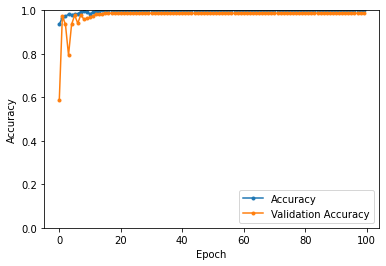

In [ ]:
import pandas
from matplotlib import pyplot as plt
df = pandas.read_csv(path_save+MODEL_NAME+'/model_history_log.csv')

def print_metric(m1,m2,title, xlabel, ylabel, metrics_name):
    plt.figure()
    plt.plot(m1, marker='.')
    plt.plot(m2, marker='.')
    #plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(metrics_name, loc="lower right")
    plt.ylim(0,1.0)
    plt.show()


#print_metric(df['loss'], df['val_loss'], 'Model loss', 'Epoch', 'Loss', ['Loss','Validation loss'])
print_metric(df['acc'], df['val_acc'], 'Model accuracy', 'Epoch', 'Accuracy', ['Accuracy','Validation Accuracy'])
#print_metric(df['auc'], df['val_auc'], 'Model AUC', 'Epoch', 'AUC', ['AUC','Validation AUC'])

Load best model and make predictions

In [ ]:
# Already made predictions?
predictions_made = True

use_preprocessing = False


In [ ]:
old = False

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
model = None
if predictions_made:
  model, best_epoch = load_best_model(old)
  # summarize model.
  model.summary()
  list_pred = glob.glob(path_save+MODEL_NAME+'/*.npy')
  name_pred = os.path.basename(max(list_pred, key=os.path.getctime))
  pred = np.load(path_save+MODEL_NAME+'/'+name_pred)
else:
  model, best_epoch = load_best_model(old)
  # summarize model.
  model.summary() 
  print(best_epoch)
  if use_preprocessing:
    X_test -= 0.5
    X_test *= 2  
  pred = model.predict(X_test, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
  np.save(path_save+MODEL_NAME+'/predictions'+str(best_epoch), pred)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
_________________________________________________________________________________

Plot CNN model

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Class assignation

In [ ]:
from scipy.optimize import fmin
from sklearn.metrics import accuracy_score
if cfg["activation"] == "sigmoid" and cfg["logits"] == 1:
  def thr_to_accuracy(thr, Y_test, predictions):
    return - accuracy_score(Y_test, np.array(predictions>thr, dtype=np.int))

  best_thr = fmin(thr_to_accuracy, args=(test_generator.classes, pred), x0=0.6)
  print(best_thr)
  predicted = [1 if i > best_thr else 0 for i in pred]
  
else:
  predicted = np.argmax(pred, axis=1)
  

In [ ]:
print(predicted)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0
 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

Classification report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


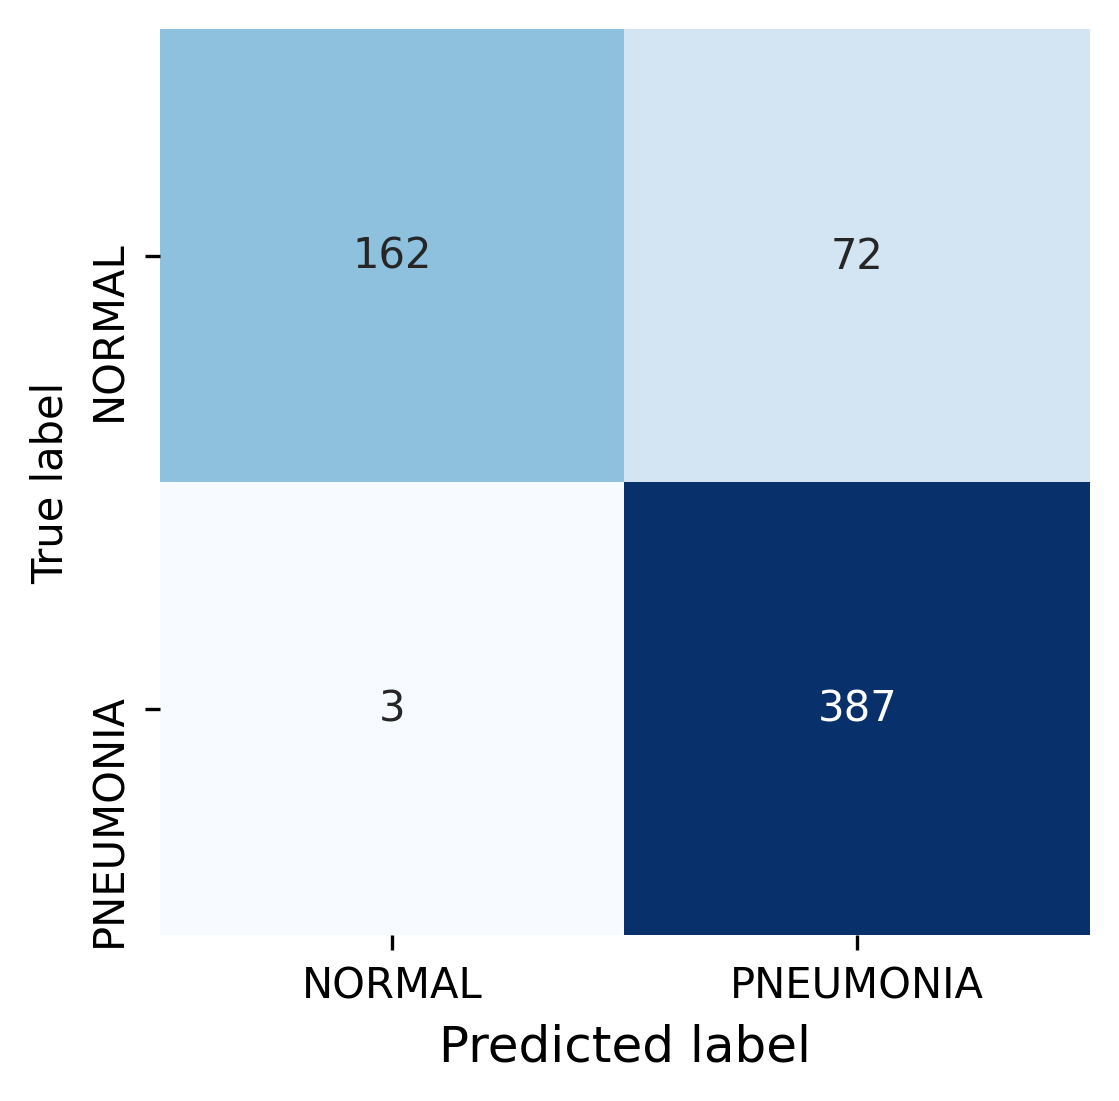


Classification Report
              precision    recall  f1-score   support

      NORMAL       0.98      0.69      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

class_names = ['NORMAL', 'PNEUMONIA']
cm = confusion_matrix(Y_test, predicted)
plt.figure(2, figsize=(4,4), dpi=300)
#ax.set(title='Confusion matrix')

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'

#sn.set(font_scale=1.5) #for label size
heatmap_cm = sns.heatmap(df_cm, annot=True, fmt='d',  cbar=False, cmap=plt.cm.Blues)

sns.set(font_scale=1)
#plt.title('Confusion Matrix')
plt.xlabel('Predicted label',fontsize=12)
plt.show()
print()
print('Classification Report')
print(classification_report(Y_test, predicted, target_names=class_names))

In [ ]:

#For pneumonia
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn/(tn+fp)

print("Accuracy of the model is {:.3f}".format(accuracy))
print("Precision of the model is {:.3f}".format(precision))
print("Recall of the model is {:.3f}".format(recall))
print("Specificity of the model is {:.3f}".format(specificity))
print("F1-Score of the model is {:.3f}".format(f1))

Accuracy of the model is 0.880
Precision of the model is 0.843
Recall of the model is 0.992
Specificity of the model is 0.692
F1-Score of the model is 0.912


ROC and AUC

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_roc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_testc[:, i], pred[:, i] )
    roc_auc[i] = auc_roc(fpr[i], tpr[i])

# micro calculate metrics globally considerig each element of the label indicator matrix as a label.
#fpr, tpr, _ = roc_curve(Y_test, predicted)
fpr["micro"], tpr["micro"], _ = roc_curve(Y_testc.ravel(), pred.ravel())
roc_auc["micro"] = auc_roc(fpr["micro"], tpr["micro"])



#roc_auc = auc_roc(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(Y_testc[:, i], pred[:, i], average='weighted'))

0.9677569581415735


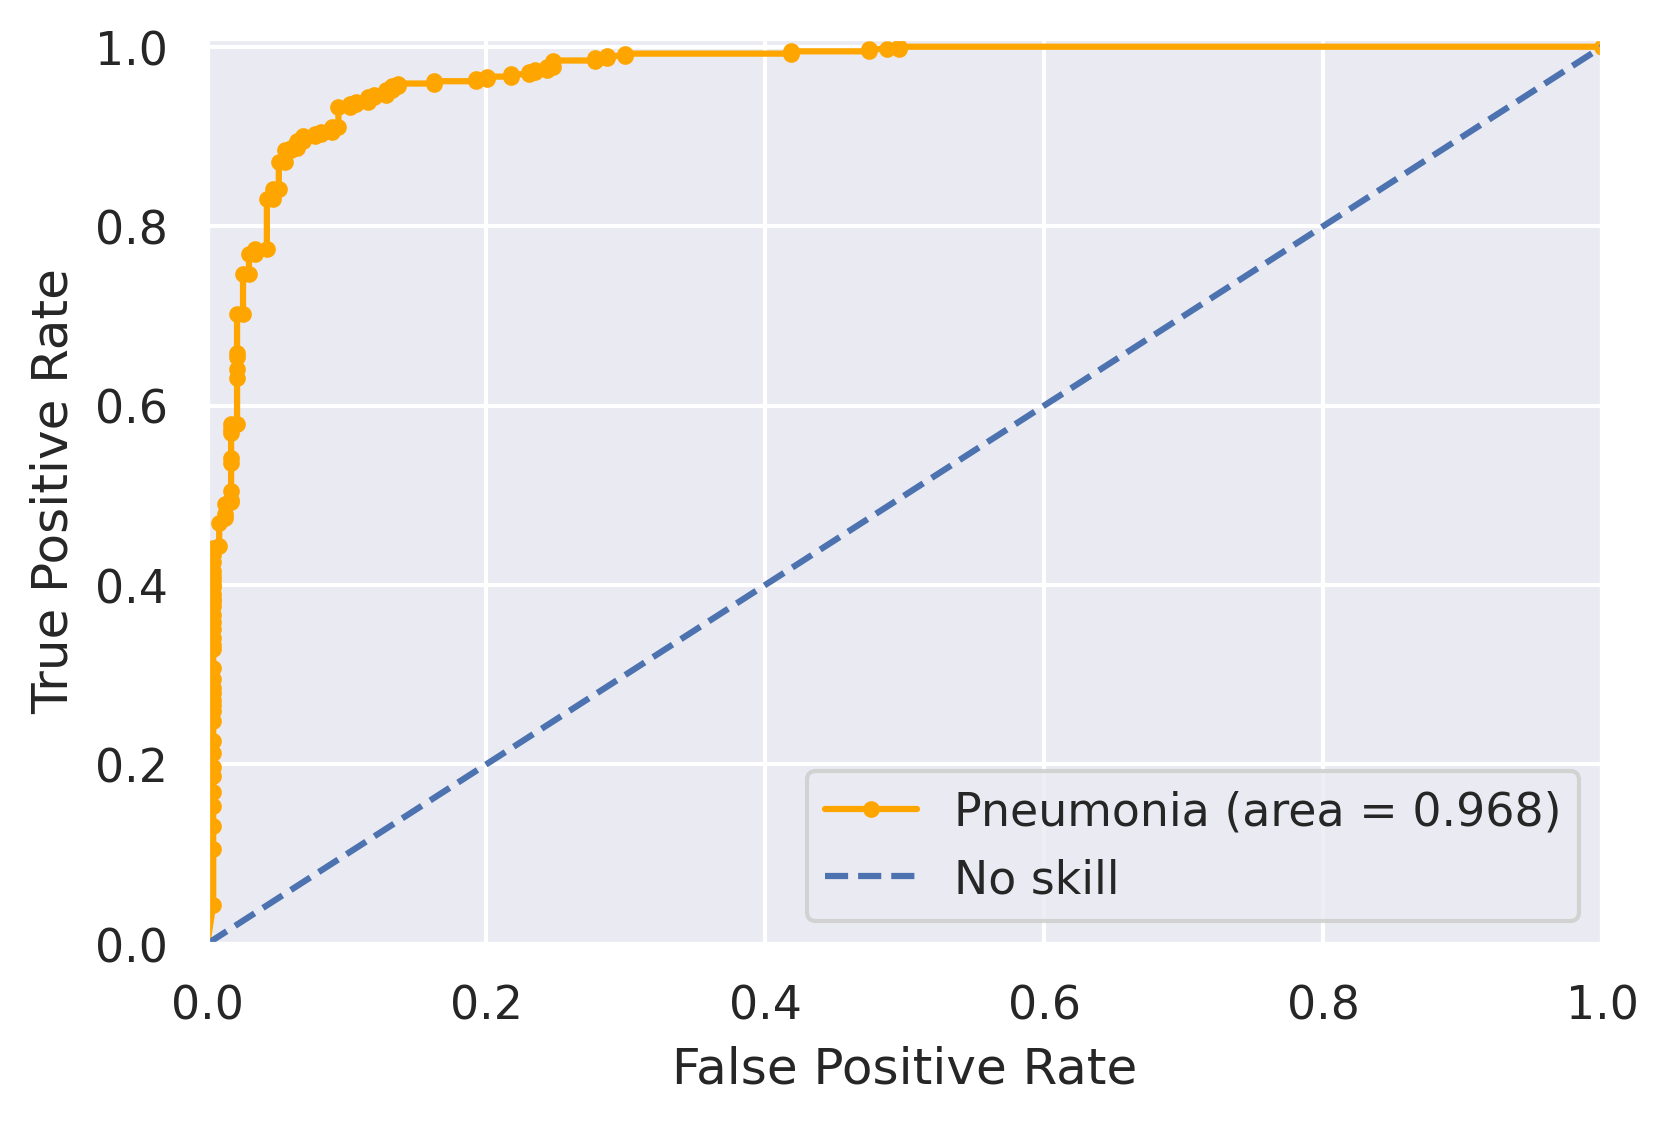

In [ ]:
plt.figure(dpi=300)
lw = 2

#plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw,
#        label='Normal (area = {0:.3f})'.format(roc_auc[0]))
plt.plot(fpr[1], tpr[1], color='orange', marker='.',
          label='Pneumonia (area = {0:.3f})'.format(roc_auc[1]))
plt.plot([0, 1], [0, 1],  linestyle='--', label='No skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Precision-Recall Curves


In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Y_testc[:, 1], pred[:, 1])

from sklearn.metrics import f1_score
yhat = predicted
lr_f1, lr_auc = f1_score(Y_test, yhat), auc_roc(recall, precision)


Plot Precision-Recall Curve

In [ ]:
plt.figure(dpi=300)
plt.plot([0, 1], [0, 0], '--', label="No skill")
plt.plot(recall, precision, color='red', marker='.',label='Pneumonia (area = {0:.3f})'.format(lr_auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()


_____
## Grad-CAM for gradients visualization
_____

Open custom image

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

'person61_bacteria_297'

path_img = '/content/drive/My Drive/CIC/Thesis/02 Images/Annotated/person61_bacteria_297.jpeg'
x_original = cv2.imread(path_img)
x_original = cv2.resize(x_original, (299,299))
x = np.float32(x_original.copy())
x -= x_train_mean
x /= x_train_std

[[8.9762245e-05 9.9991024e-01]]


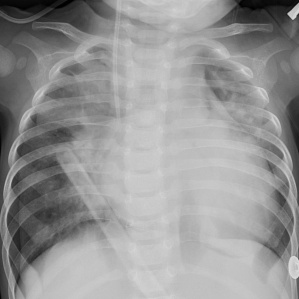

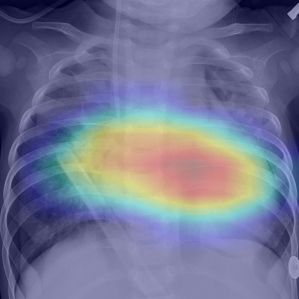

[[9.345036e-09 1.000000e+00]]


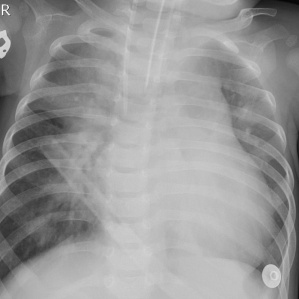

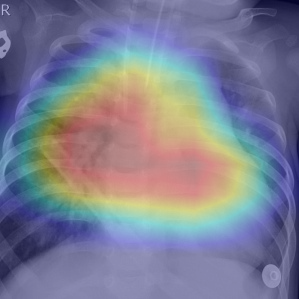

[[0.00413483 0.9958652 ]]


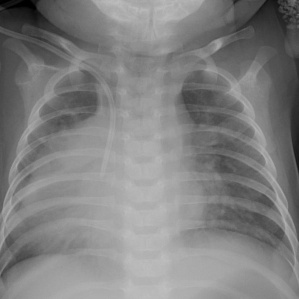

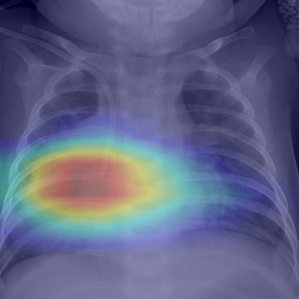

[[1.3571267e-06 9.9999869e-01]]


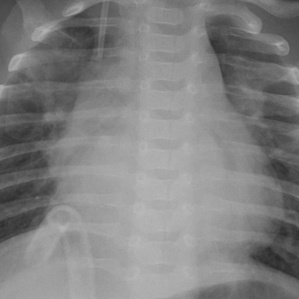

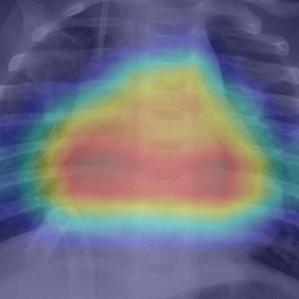

[[1.5691374e-05 9.9998426e-01]]


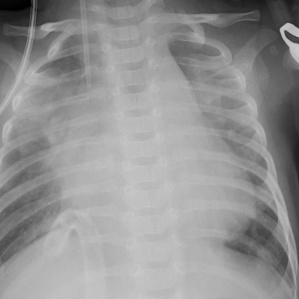

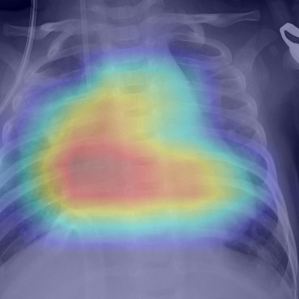

[[2.012569e-06 9.999980e-01]]


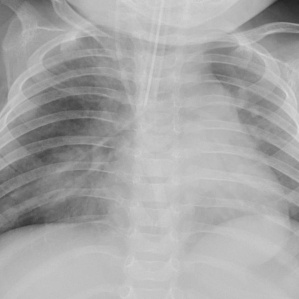

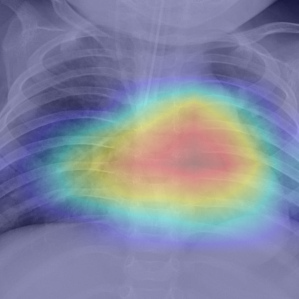

[[3.535459e-06 9.999964e-01]]


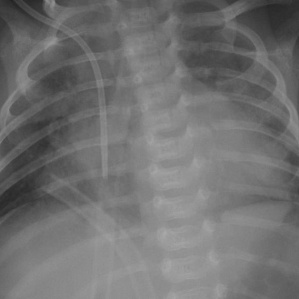

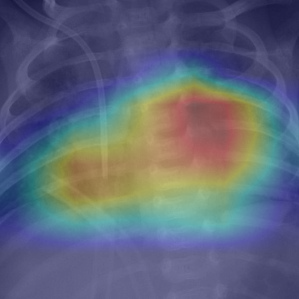

In [ ]:

#imgs = [-10,-50,-21,-22,-23,-31]
#imgs=[1958]
#imgs = [1143,1144,1145,1146,1147,1148,1149,1150]
#imgs = [16,45,46,47,48,49] #Images of NORMAL patients
imgs = [-5,-6,-7,-8,-9,-12,-13]
for i in imgs:
  n_img = i
  x = X_test[n_img]
  x = np.expand_dims(x, axis=0)
  #print(x.shape)

  grad_cam(x)

Use trained model to predic output and get last convolutional layer

In [ ]:
def grad_cam(x):
  class_output = pred_x(x)
  conv_value = grad_computation(class_output)
  heatmap = generate_heatmap(conv_value)
  show_CAM(heatmap)

In [ ]:
def pred_x(x):
  preds = model.predict(x)
  print(preds)
  if cfg["activation"] == "sigmoid" and cfg["logits"] == 1:
    class_idx = 1 if preds[0] > best_thr else 0
    class_output = model.output[:, 0]
  else:
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]

  return class_output


Computing gradients of the class output with respect to the feature map. Pooling gradients over all the axes leaving out the channel dimension. Weight te output feature map with computed gradient values

In [ ]:
def grad_computation(class_output):
  last_conv_layer = model.get_layer("block14_sepconv2")
  from tensorflow.keras import backend as K
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0,1,2))
  #print(pooled_grads)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(2048):
    #print(pooled_grads_value[i])
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

  return conv_layer_output_value

Generating heat map

In [ ]:
def generate_heatmap(conv_layer_output_value):
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  #plt.matshow(heatmap)
  #plt.show()
  #print(heatmap.shape)

  return heatmap

Evaluating-showing heatmap

In [ ]:
def show_CAM(heatmap):
  import cv2
  from google.colab.patches import cv2_imshow
  img = X_test_original[n_img]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
  cv2_imshow(img)
  cv2_imshow(superimposed_img)


_____
Finish program
_____

## Metrics for predicted models

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def get_metrics(MODEL_NAME):
  list_pred = glob.glob(path_save+MODEL_NAME+'/*.npy')
  name_pred = os.path.basename(max(list_pred, key=os.path.getctime))
  pred = np.load(path_save+MODEL_NAME+'/'+name_pred)
  predicted = np.argmax(pred, axis=1)
  class_names = ['Normal', 'Pneumonia']
  cm = confusion_matrix(Y_test, predicted)
  tn, fp, fn, tp = cm.ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  return precision, recall, f1, pred

In [ ]:

import pandas as pd
path_save = '/content/drive/My Drive/Colab Notebooks/Models/PneumoniaDN/'





NAMES = ['Xception-TF_30e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_WeightedSK',
'Xception-TF_20e_Adam_lr1e-3_GAP-Soft_Rotation_WeightedSK_01',
'Xception-TF_80e_Adam_lr5e-3_GAP-128H-Soft_Rotation_WeightedSK',
'Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_Mweights',
'CustomTest_1e-3_200e',
'Xception-TF_80e_Adam_lr5e-3_GAP-Soft_Rotation_WeightedSK',
'Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_WeightedSK_Resized',
'Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-NDO-Soft_Rotation_WeightedSK',
'Xception-UB_50e_Adam_lr1e-3_GAP-Soft_WeightedSK_2_split01',
'ResNet50v2-TF_30e_Adam_lr1e-3_GAP-128H-Soft_Rotation_WeightedSK',
'ResNet20v2-_150e_Adam_lr1e-3_GAP-128H-Soft_Rotation_24f_WeightedSK',
'CustomNet_Concat_Add_1e-3_150e',
'ResNet50v2-TF_80e_Adam_lr5e-3_GAP-Soft_Rotation_WeightedSK',
'ResNet20v2-_150e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_16f_WeightedSK',
'ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_24f_WeightedSK',
'ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_16f_WeightedSK',
'ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_32f_WeightedSK',
'CustomTestConcat_5e-4_200e'
         ]
results = {}
for MODEL_NAME in NAMES:
  precision, recall, f1 = get_metrics(MODEL_NAME)
  print(MODEL_NAME)
  results[MODEL_NAME] = [precision, recall, f1]
#print("Precision of the model is {:.3f}".format(precision))
#print("Recall of the model is {:.3f}".format(recall))
#print("F1-Score of the model is {:.3f}".format(f1))

dfmetrics = pd.DataFrame.from_dict(results, orient='index', columns=['precision','recall','f1'])
dfmetrics.to_csv ('results_UB.csv', index = True, header=True)
#import csv

#with open('results_us.csv', 'w', newline='') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(results)

Xception-TF_30e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_WeightedSK
Xception-TF_20e_Adam_lr1e-3_GAP-Soft_Rotation_WeightedSK_01
Xception-TF_80e_Adam_lr5e-3_GAP-128H-Soft_Rotation_WeightedSK
Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_Mweights
CustomTest_1e-3_200e
Xception-TF_80e_Adam_lr5e-3_GAP-Soft_Rotation_WeightedSK
Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-Soft_Rotation_WeightedSK_Resized
Xception-TF_20e_Adam_lr5e-4_20Freeze-GAP-NDO-Soft_Rotation_WeightedSK
Xception-UB_50e_Adam_lr1e-3_GAP-Soft_WeightedSK_2_split01
ResNet50v2-TF_30e_Adam_lr1e-3_GAP-128H-Soft_Rotation_WeightedSK
ResNet20v2-_150e_Adam_lr1e-3_GAP-128H-Soft_Rotation_24f_WeightedSK
CustomNet_Concat_Add_1e-3_150e
ResNet50v2-TF_80e_Adam_lr5e-3_GAP-Soft_Rotation_WeightedSK
ResNet20v2-_150e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_16f_WeightedSK
ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_24f_WeightedSK
ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_16f_WeightedSK
ResNet20v2-_80e_Adam_lr5e-3_GAP-Soft-NoHidden_Rot_3

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_roc

precision, recall, f1, pred = get_metrics('CustomTestConcat_5e-4_200e')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_testc[:, i], pred[:, i])
    roc_auc[i] = auc_roc(fpr[i], tpr[i])

#fpr, tpr, _ = roc_curve(Y_test, predicted)
fpr["macro"], tpr["macro"], _ = roc_curve(Y_testc.ravel(), pred.ravel())
roc_auc["macro"] = auc_roc(fpr["macro"], tpr["macro"])
#roc_auc = auc_roc(fpr, tpr)

In [ ]:
print('Pneumonia (area = {0:.3f})'.format(roc_auc[1]))

Pneumonia (area = 0.916)


## GPU info

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ea1dd0be-17bc-89e1-c502-705af5ce8a98)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Fri May  1 20:48:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    66W / 149W |  11051MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

Socket(s):           1


In [ ]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:  2


In [ ]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2


In [ ]:
!lscpu | grep "L3 cache"

L3 cache:            46080K


In [ ]:
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

CPU MHz:             2300.000
